In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

# Try Encoding Categorical Feature with Ordinal (Currently Best)

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.shape

(48895, 16)

In [3]:
print(find_outlier(df['price']))

(-90.0, 334.0, array([375, 800, 500, ..., 800, 350, 345]))


In [4]:
df = df[df['price'] < 335]
df.shape

(45923, 16)

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.fillna(0, inplace=True)

In [7]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [8]:
Temp_dict2 = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
df['room_type'] = df['room_type'].map(Temp_dict2)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,2,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,3,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,2,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,3,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,3,80,10,9,0.10,1,0


In [9]:
Temp_dict = {'Bronx': 1, 'Staten Island': 2, 'Queens': 3, 'Brooklyn': 4, 'Manhattan': 5}
df['neighbourhood_group'] = df['neighbourhood_group'].map(Temp_dict)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,Kensington,40.64749,-73.97237,2,149,1,9,0.21,6,365
1,5,Midtown,40.75362,-73.98377,3,225,1,45,0.38,2,355
2,5,Harlem,40.80902,-73.94190,2,150,3,0,0.00,1,365
3,4,Clinton Hill,40.68514,-73.95976,3,89,1,270,4.64,1,194
4,5,East Harlem,40.79851,-73.94399,3,80,10,9,0.10,1,0


In [10]:
temp_dict = {}
for i, v in enumerate(df.groupby('neighbourhood').mean()['price'].sort_values(ascending=True).items()):
#     print(v[0], i+1)
    temp_dict[v[0]] = i+1
temp_dict

{"Bull's Head": 1,
 'Hunts Point': 2,
 'Tremont': 3,
 'Soundview': 4,
 'Corona': 5,
 'New Dorp': 6,
 'Bronxdale': 7,
 'New Dorp Beach': 8,
 'Grant City': 9,
 'Concord': 10,
 'Mount Eden': 11,
 'Woodlawn': 12,
 'Westchester Square': 13,
 'Castle Hill': 14,
 'Borough Park': 15,
 'Olinville': 16,
 'Woodhaven': 17,
 'Arden Heights': 18,
 'Emerson Hill': 19,
 'Graniteville': 20,
 'Parkchester': 21,
 'Schuylerville': 22,
 'Morris Park': 23,
 'Fordham': 24,
 'University Heights': 25,
 'Silver Lake': 26,
 'College Point': 27,
 'Highbridge': 28,
 'Westerleigh': 29,
 'Rosedale': 30,
 'Kingsbridge': 31,
 'Concourse Village': 32,
 'South Ozone Park': 33,
 'Rossville': 34,
 'Fieldston': 35,
 'Ridgewood': 36,
 'Little Neck': 37,
 'Baychester': 38,
 'Norwood': 39,
 'Bensonhurst': 40,
 'New Springville': 41,
 'Tompkinsville': 42,
 'Claremont Village': 43,
 'Brownsville': 44,
 'Randall Manor': 45,
 'Morris Heights': 46,
 'Cypress Hills': 47,
 'Belmont': 48,
 'Co-op City': 49,
 'Mount Hope': 50,
 'Elmhu

In [11]:
df['neighbourhood'] = df['neighbourhood'].map(temp_dict)

In [12]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,97,40.64749,-73.97237,2,149,1,9,0.21,6,365
1,5,211,40.75362,-73.98377,3,225,1,45,0.38,2,355
2,5,144,40.80902,-73.94190,2,150,3,0,0.00,1,365
3,4,161,40.68514,-73.95976,3,89,1,270,4.64,1,194
4,5,151,40.79851,-73.94399,3,80,10,9,0.10,1,0


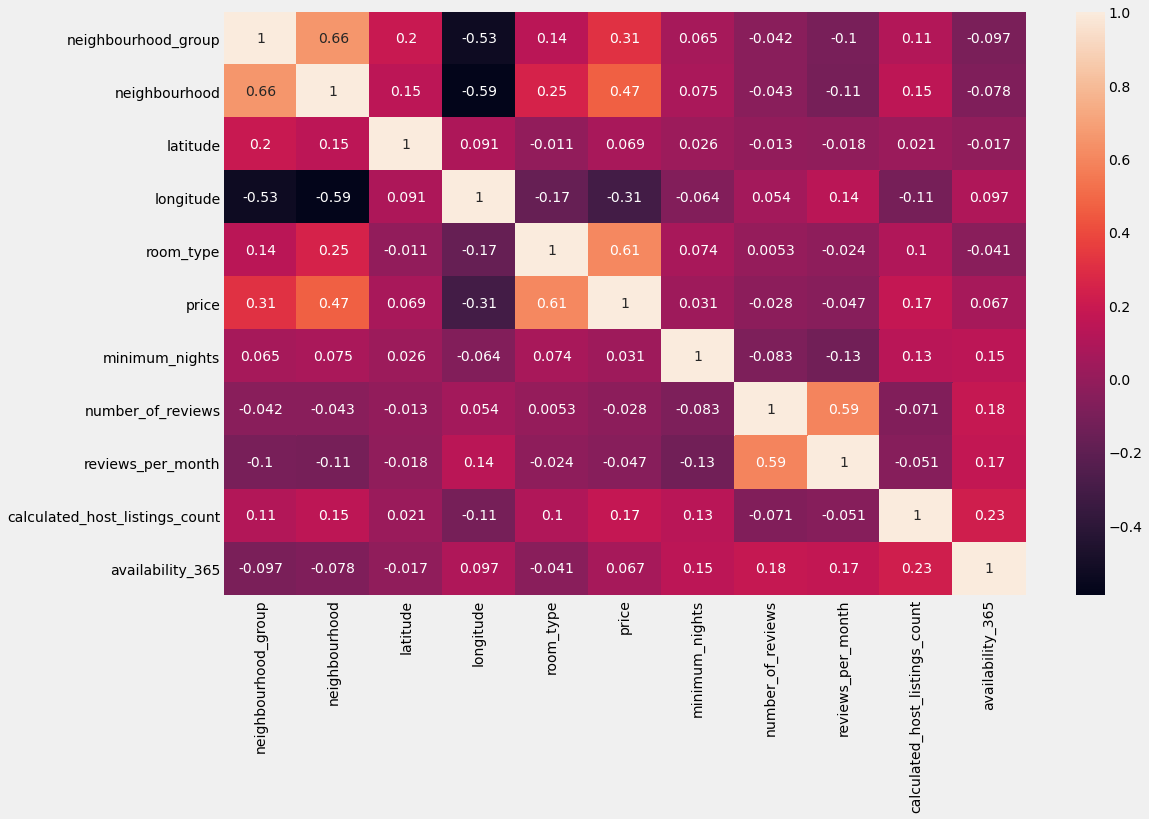

In [13]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=True);

In [14]:
# Splitting Dataset
x = df.drop(columns='price')
y = df['price']

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scaling
x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

## Model ML

Model	 = LinearRegression()
RMSE	 = 48.7
MAE	 = 36.21
R2 Score = 49.09
cross_val_score = [0.43643673 0.48925794 0.47340035 0.50104611 0.51592952]
cross_val_score = [-48.64389698 -47.08434689 -47.27656538 -48.85820058 -51.71705198]


,Actual Price,Predicted Price
0,42,31.260545
1,75,49.443010
2,168,182.307181
3,125,144.266344
4,300,142.657864
5,150,157.383350
6,39,60.701205
7,40,103.598211
8,49,40.279232
9,83,168.712406


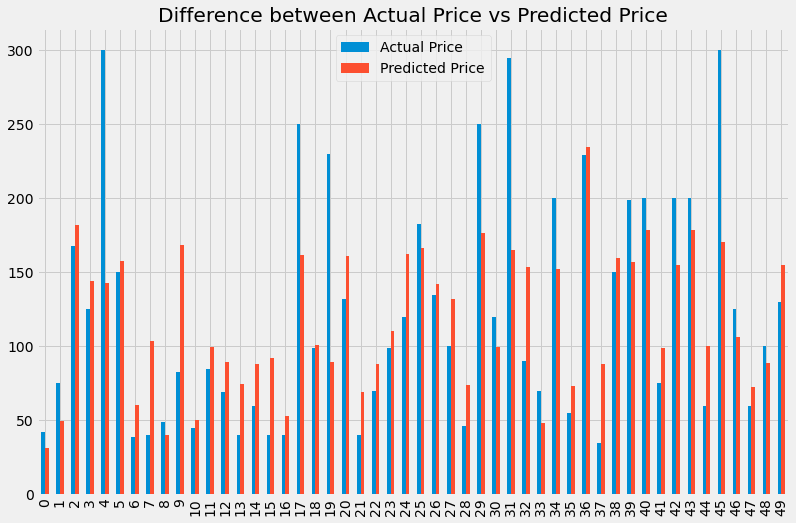



Model	 = Lasso()
RMSE	 = 48.77
MAE	 = 36.27
R2 Score = 48.93
cross_val_score = [0.43660293 0.48768785 0.47178638 0.50040799 0.5087817 ]
cross_val_score = [-48.63672391 -47.15666329 -47.34895903 -48.88943351 -52.09748187]


,Actual Price,Predicted Price
0,42,35.853790
1,75,55.668566
2,168,177.257335
3,125,148.786864
4,300,143.624505
5,150,156.422475
6,39,60.846708
7,40,99.087196
8,49,44.051160
9,83,167.796861


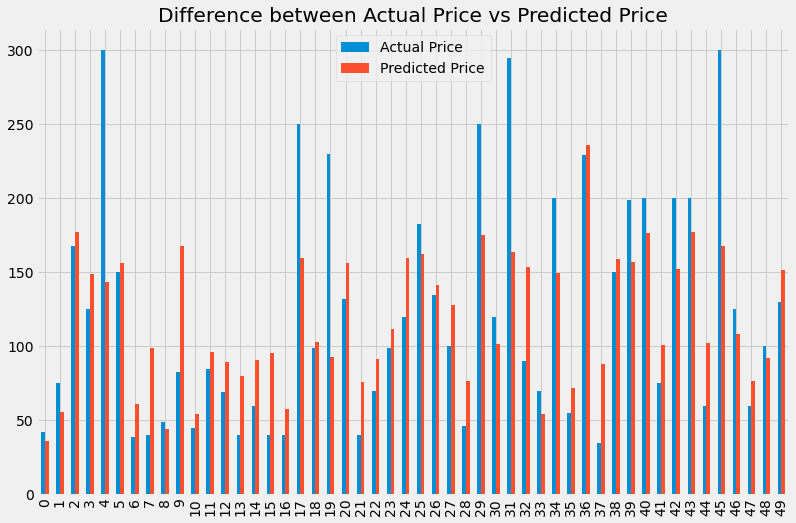



Model	 = Ridge()
RMSE	 = 48.7
MAE	 = 36.21
R2 Score = 49.09
cross_val_score = [0.43643943 0.4892497  0.47341519 0.50109775 0.51589212]
cross_val_score = [-48.64378071 -47.08472671 -47.27589939 -48.85567206 -51.71905001]


,Actual Price,Predicted Price
0,42,31.263679
1,75,49.446925
2,168,182.302777
3,125,144.260224
4,300,142.655386
5,150,157.381307
6,39,60.703424
7,40,103.600239
8,49,40.288148
9,83,168.709949


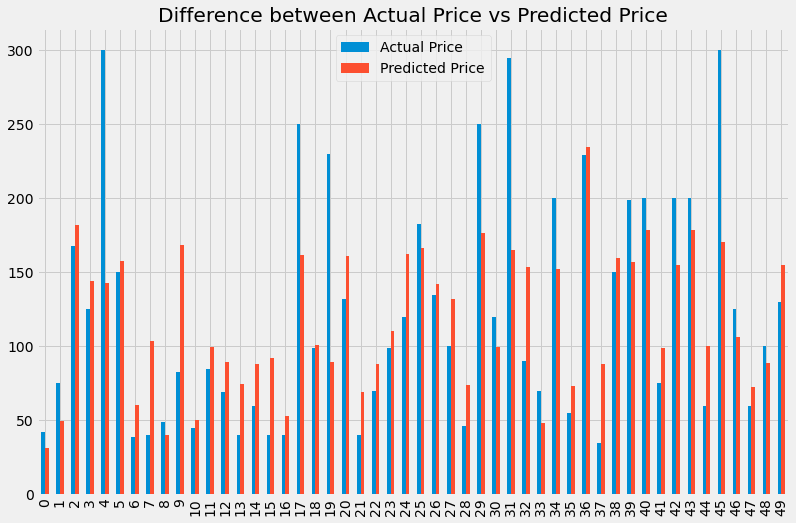



Model	 = ElasticNet()
RMSE	 = 54.7
MAE	 = 42.19
R2 Score = 35.77
cross_val_score = [0.3303975  0.3782027  0.36672804 0.39395906 0.38171249]
cross_val_score = [-53.02315338 -51.9517469  -51.84427029 -53.84659467 -58.44867885]


,Actual Price,Predicted Price
0,42,61.872513
1,75,81.425314
2,168,148.668907
3,125,108.683883
4,300,126.632541
5,150,141.060903
6,39,83.006191
7,40,115.805866
8,49,97.162995
9,83,147.850440


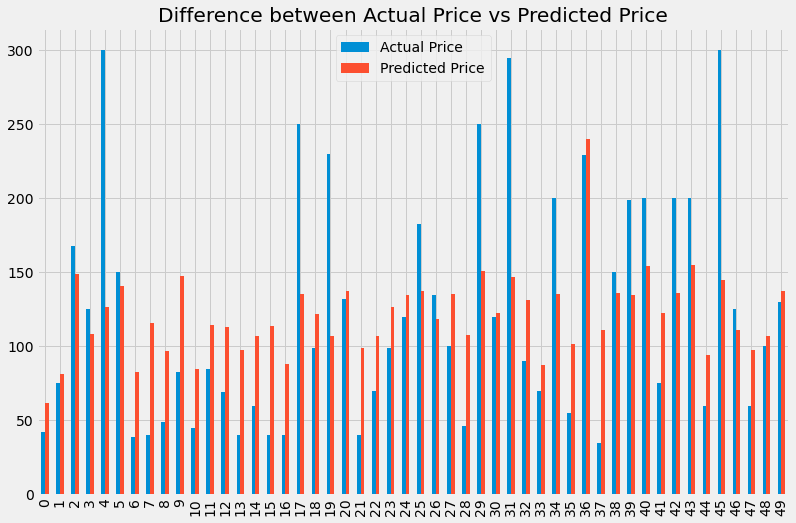



Model	 = RandomForestRegressor()
RMSE	 = 44.83
MAE	 = 32.02
R2 Score = 56.86
cross_val_score = [0.47429338 0.53852514 0.53034433 0.56683306 0.53940239]
cross_val_score = [-46.94258524 -44.76115314 -44.62762856 -45.45617961 -50.41537246]


,Actual Price,Predicted Price
0,42,50.37
1,75,70.84
2,168,191.56
3,125,138.65
4,300,108.32
5,150,190.28
6,39,51.65
7,40,59.91
8,49,93.04
9,83,164.84


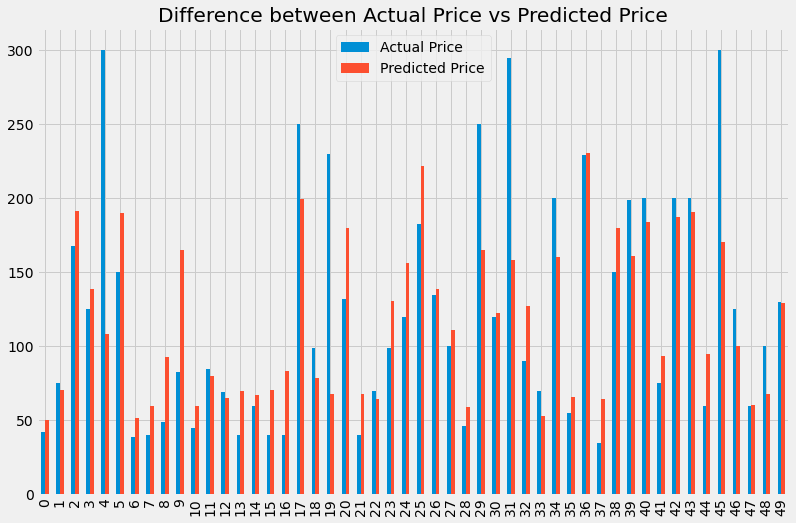

In [15]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor()]
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
    print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))
    print('cross_val_score =', cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5))
    result = pd.DataFrame({'Actual Price' : np.array(y_test).flatten(),
                'Predicted Price' : np.array(y_pred).flatten()
                 }).head(50)
    display(result.head(20))
    result.plot(kind='bar', figsize=(12, 8))
    plt.title('Difference between Actual Price vs Predicted Price')
    plt.show()
    
    print('\n')

In [16]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet()]
for i in linear:
    model = i
    poly_reg = make_pipeline(
        PF(2, include_bias=False),
        i
    )

    poly_reg.fit(x_train, y_train)
    # predict
    y_pred = poly_reg.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
    print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))
    print('cross_val_score =', cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5))
    
    print('\n')

Model	 = LinearRegression()
RMSE	 = 47.1
MAE	 = 33.75
R2 Score = 52.38
cross_val_score = [0.43643673 0.48925794 0.47340035 0.50104611 0.51592952]
cross_val_score = [-48.64389698 -47.08434689 -47.27656538 -48.85820058 -51.71705198]


Model	 = Lasso()
RMSE	 = 47.33
MAE	 = 34.25
R2 Score = 51.91
cross_val_score = [0.43660293 0.48768785 0.47178638 0.50040799 0.5087817 ]
cross_val_score = [-48.63672391 -47.15666329 -47.34895903 -48.88943351 -52.09748187]


Model	 = Ridge()
RMSE	 = 47.1
MAE	 = 33.75
R2 Score = 52.38
cross_val_score = [0.43643943 0.4892497  0.47341519 0.50109775 0.51589212]
cross_val_score = [-48.64378071 -47.08472671 -47.27589939 -48.85567206 -51.71905001]


Model	 = ElasticNet()
RMSE	 = 51.25
MAE	 = 38.34
R2 Score = 43.62
cross_val_score = [0.3303975  0.3782027  0.36672804 0.39395906 0.38171249]
cross_val_score = [-53.02315338 -51.9517469  -51.84427029 -53.84659467 -58.44867885]




---

---

# Try Feature Selection 

In [17]:
df1 = df.copy()
# neighbourhood, room_type, neighbourhood_group, longitude, calculated_host_listings_count
df1 = df1[['neighbourhood', 'room_type', 'neighbourhood_group', 'longitude', 'calculated_host_listings_count', 'price']]
df1

,neighbourhood,room_type,neighbourhood_group,longitude,calculated_host_listings_count,price
0,97,2,4,-73.97237,6,149
1,211,3,5,-73.98377,2,225
2,144,2,5,-73.94190,1,150
3,161,3,4,-73.95976,1,89
4,151,3,5,-73.94399,1,80
...,...,...,...,...,...,...
48890,122,2,4,-73.94995,2,70
48891,62,2,4,-73.93317,2,40
48892,144,3,5,-73.94867,1,115
48893,199,1,5,-73.99112,6,55


In [18]:
# Splitting Dataset
x1 = df1.drop(columns='price')
y1 = df1['price']

# train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# Scaling
x1_train = RobustScaler().fit_transform(x1_train)
x1_test = RobustScaler().fit_transform(x1_test)

Model	 = LinearRegression()
RMSE	 = 49.33
MAE	 = 36.79
R2 Score = 47.77
cross_val_score = [0.43215573 0.47237476 0.45616057 0.49562288 0.47990547]
cross_val_score = [-48.82830444 -47.85623399 -48.04420194 -49.12300793 -53.60688931]


,Actual Price,Predicted Price
0,42,33.096479
1,75,59.937699
2,168,172.628761
3,125,153.687792
4,300,149.020113
5,150,172.005102
6,39,53.309250
7,40,90.269243
8,49,43.077773
9,83,173.867894


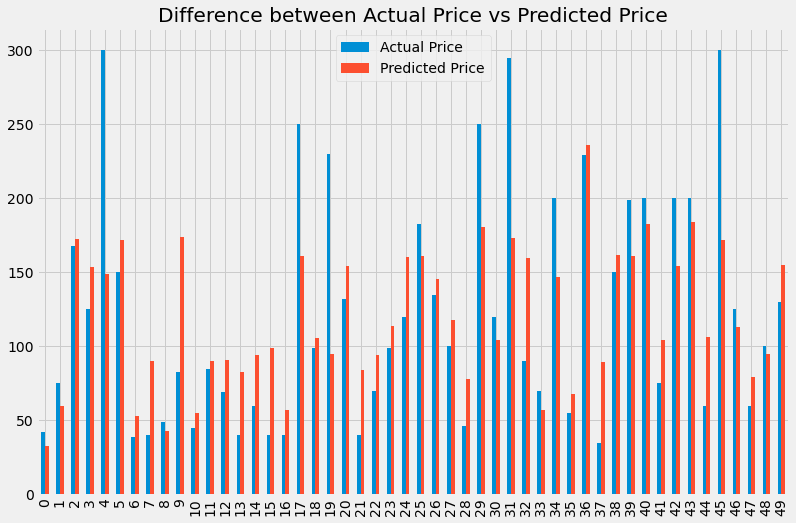



Model	 = Lasso()
RMSE	 = 49.39
MAE	 = 36.85
R2 Score = 47.63
cross_val_score = [0.43161152 0.47068359 0.45539614 0.49540035 0.47630222]
cross_val_score = [-48.85169698 -47.93286848 -48.07795584 -49.1338429  -53.79226481]


,Actual Price,Predicted Price
0,42,36.926915
1,75,62.787376
2,168,170.112800
3,125,153.177949
4,300,147.614059
5,150,169.412644
6,39,56.627599
7,40,91.134835
8,49,46.418546
9,83,171.163783


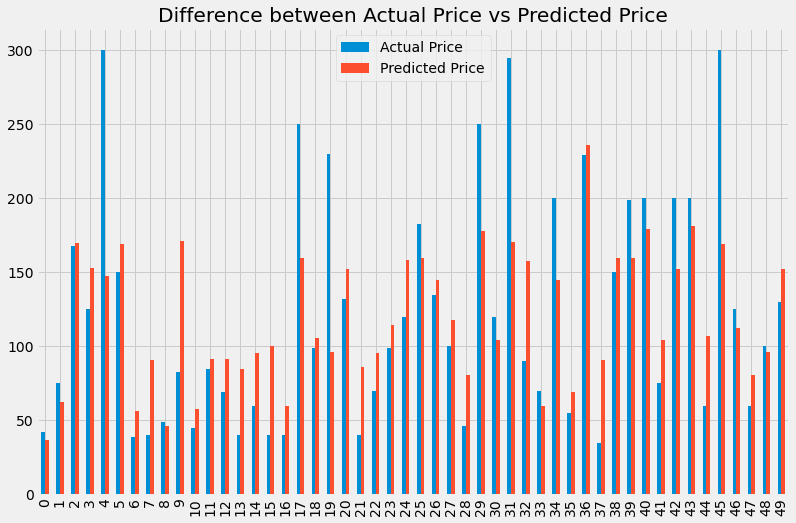



Model	 = Ridge()
RMSE	 = 49.33
MAE	 = 36.79
R2 Score = 47.77
cross_val_score = [0.43215258 0.47236613 0.45616438 0.49565014 0.47990686]
cross_val_score = [-48.82843994 -47.85662554 -48.04403347 -49.12168027 -53.60681772]


,Actual Price,Predicted Price
0,42,33.099418
1,75,59.940409
2,168,172.625378
3,125,153.680940
4,300,149.017116
5,150,172.001888
6,39,53.312355
7,40,90.272659
8,49,43.086013
9,83,173.864921


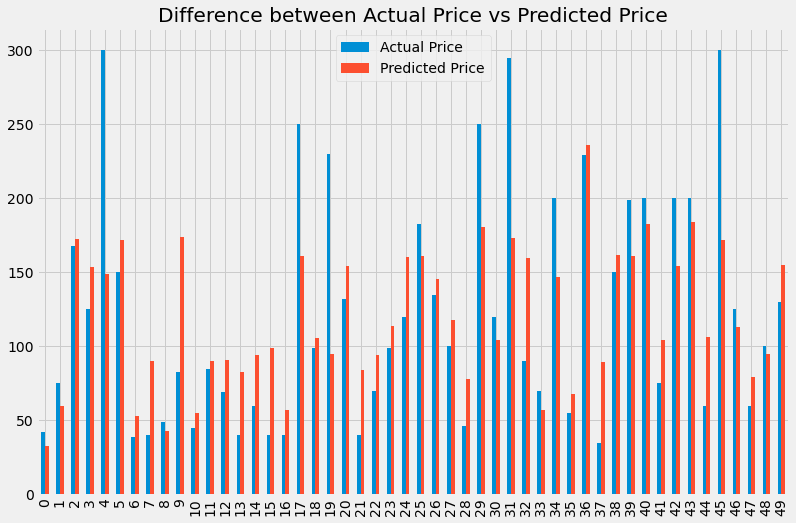



Model	 = ElasticNet()
RMSE	 = 54.95
MAE	 = 42.39
R2 Score = 35.19
cross_val_score = [0.32791656 0.36291753 0.35079987 0.39411625 0.35659384]
cross_val_score = [-53.12129054 -52.58641525 -52.49221927 -53.83961117 -59.62413202]


,Actual Price,Predicted Price
0,42,62.499592
1,75,83.799416
2,168,146.141377
3,125,112.105621
4,300,128.714952
5,150,146.300988
6,39,81.370302
7,40,112.092661
8,49,97.030375
9,83,149.204730


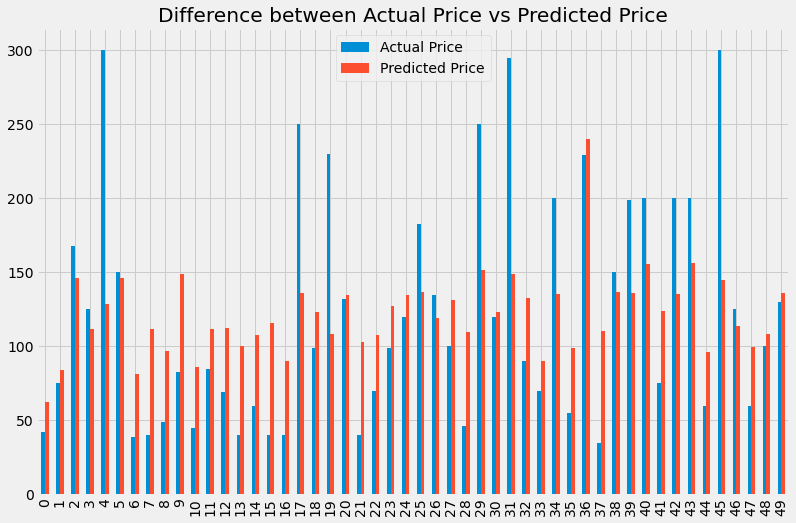



Model	 = RandomForestRegressor()
RMSE	 = 51.97
MAE	 = 37.07
R2 Score = 42.02
cross_val_score = [0.29598706 0.37210367 0.37219697 0.44512232 0.42888427]
cross_val_score = [-54.25502372 -52.26287362 -51.61622294 -51.45976024 -56.16595062]


,Actual Price,Predicted Price
0,42,45.850000
1,75,63.760000
2,168,132.050000
3,125,142.300000
4,300,144.190000
5,150,206.750000
6,39,43.310000
7,40,131.190000
8,49,84.326000
9,83,173.950000


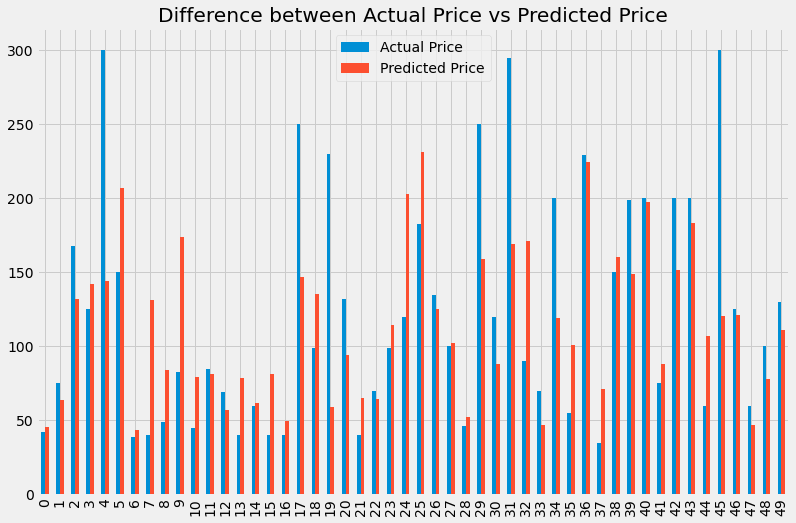

In [19]:
linear = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor()]
for i in linear:
    model = i
    model.fit(x1_train, y1_train)
    y_pred = model.predict(x1_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y1_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y1_test,y_pred) * 100 , 2)}')
    print('cross_val_score =', cross_val_score(model, x1, y1, scoring='r2',cv=5))
    print('cross_val_score =', cross_val_score(model, x1, y1, scoring='neg_root_mean_squared_error',cv=5))
    result = pd.DataFrame({'Actual Price' : np.array(y1_test).flatten(),
                'Predicted Price' : np.array(y_pred).flatten()
                 }).head(50)
    display(result.head(20))
    result.plot(kind='bar', figsize=(12, 8))
    plt.title('Difference between Actual Price vs Predicted Price')
    plt.show()
    
    print('\n')

---

# Final DataFrame (RandomForestRegressor)

In [20]:
import joblib

In [31]:
df#[df['price'] == 75]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4,97,40.64749,-73.97237,2,149,1,9,0.21,6,365
1,5,211,40.75362,-73.98377,3,225,1,45,0.38,2,355
2,5,144,40.80902,-73.94190,2,150,3,0,0.00,1,365
3,4,161,40.68514,-73.95976,3,89,1,270,4.64,1,194
4,5,151,40.79851,-73.94399,3,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,4,122,40.67853,-73.94995,2,70,2,0,0.00,2,9
48891,4,62,40.70184,-73.93317,2,40,4,0,0.00,2,36
48892,5,144,40.81475,-73.94867,3,115,10,0,0.00,1,27
48893,5,199,40.75751,-73.99112,1,55,1,0,0.00,6,2


In [22]:
# Splitting Dataset
x = df.drop(columns='price')
y = df['price']

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scaling
x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [23]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
joblib.dump(model, 'model_final_project_rfr')
y_pred = model.predict(x_test)
result = pd.DataFrame(
    {'Actual Price' : np.array(y_test).flatten(),
    'Predicted Price' : np.array(y_pred).flatten()
                 })
result['Predicted/Actual'] = result['Predicted Price']/result['Actual Price']
result['Risk'] = result['Predicted/Actual'].apply(lambda x: 'Prediksi < Aktual' if x < 1 else 'Prediksi > Aktual')

In [24]:
result['Risk'].value_counts()

Prediksi > Aktual    5273
Prediksi < Aktual    3912
Name: Risk, dtype: int64

In [25]:
print(f'Model\t = {model}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))
print('cross_val_score =', cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5))

Model	 = RandomForestRegressor()
RMSE	 = 44.82
MAE	 = 31.99
R2 Score = 56.88
cross_val_score = [0.47100481 0.53722461 0.5321218  0.5682837  0.53950224]
cross_val_score = [-46.94946873 -44.8499573  -44.62889061 -45.40890513 -50.56680488]


In [32]:
print(df['latitude'].min(), df['latitude'].max())
print(df['longitude'].min(), df['longitude'].max())

40.499790000000004 40.913059999999994
-74.24441999999999 -73.71299
